#Test


In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import prince
import seaborn as sns
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
%matplotlib inline

First we read the data and view the data

In [2]:
data = pd.read_csv(r'Home_Loan_App.csv')
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def get_cat(series: pd.Series, empty_flag: bool) -> str:
    """
    :param series: a pandas series of data (should be of one data type)
    :param empty_flag: a boolean to call out an empty column (containing all NaNs)
    :return: a string that is the 'category of the datatype'

    This function will take a given series and return a generalized category for the datatype.
    This is necessary for readability as df.dtypes will return ungrouped types (i.e. float64, int64)
    as well as return some options that do not provide much insight (i.e. object)
    """
    if empty_flag:  # Catch Empty Columns
        return 'Empty'
    elif pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif pd.api.types.is_bool_dtype(series):
        return 'Boolean'
    elif pd.api.types.is_categorical_dtype(series):
        return 'Categorical'
    elif pd.api.types.is_string_dtype(series):
        return 'Text'
    else:  # Catches all others for review
        return 'Unknown'


def col_categories(data: pd.DataFrame):
    """
    :param data: a pandas Dataframe consisting of columns of data you want to explore their categories
    :return: None
    Prints the column name and data type of each column in the dataframe
    """
    if data.dropna().empty:  # Catches Error
        raise ValueError('DataFrame Provided Contains is either empty or only contains NaNs')
        # sys.exit(1)
    for col in data.columns:  # For Each Column
        if data[col].dropna().empty:  # Catch Empty Columns
            empty = True  # Set Flag
        else:
            empty = False  # Set Flag
        count = data[col].nunique()
        print(col, ': ', get_cat(data[col], empty), ' -- #Unique: ', count)  # Print and Call Column Categories

In [4]:
col_categories(data)


SK_ID_CURR :  Numerical  -- #Unique:  307511
NAME_CONTRACT_TYPE :  Text  -- #Unique:  2
CODE_GENDER :  Text  -- #Unique:  3
FLAG_OWN_CAR :  Text  -- #Unique:  2
FLAG_OWN_REALTY :  Text  -- #Unique:  2
CNT_CHILDREN :  Numerical  -- #Unique:  15
AMT_INCOME_TOTAL :  Numerical  -- #Unique:  2548
AMT_CREDIT :  Numerical  -- #Unique:  5603
AMT_ANNUITY :  Numerical  -- #Unique:  13672
AMT_GOODS_PRICE :  Numerical  -- #Unique:  1002
NAME_TYPE_SUITE :  Text  -- #Unique:  7
NAME_INCOME_TYPE :  Text  -- #Unique:  8
NAME_EDUCATION_TYPE :  Text  -- #Unique:  5
NAME_FAMILY_STATUS :  Text  -- #Unique:  6
NAME_HOUSING_TYPE :  Text  -- #Unique:  6
REGION_POPULATION_RELATIVE :  Numerical  -- #Unique:  81
DAYS_BIRTH :  Numerical  -- #Unique:  17460
DAYS_EMPLOYED :  Numerical  -- #Unique:  12574
DAYS_REGISTRATION :  Numerical  -- #Unique:  15688
DAYS_ID_PUBLISH :  Numerical  -- #Unique:  6168
OWN_CAR_AGE :  Numerical  -- #Unique:  62
FLAG_MOBIL :  Numerical  -- #Unique:  2
FLAG_EMP_PHONE :  Numerical  -- 

Explain what we see, flags as numerical (but are binary) should be fine in our cluster

Lets look through a few of the variables to see the distribution (numerical with few options so
that our visuals are clean)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E24A40CF88>,
      dtype=object)

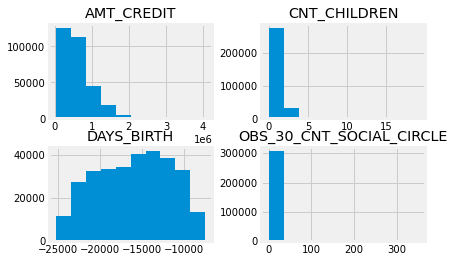

In [5]:
data[['CNT_CHILDREN', 'AMT_CREDIT', 'DAYS_BIRTH', 'OBS_30_CNT_SOCIAL_CIRCLE']].hist()


In [6]:
print("-------Percentage of Null values count------")
for feature in data.columns.values:
    print(feature,"-->",100*data[feature].isnull().sum()/len(data))


-------Percentage of Null values count------
SK_ID_CURR --> 0.0
NAME_CONTRACT_TYPE --> 0.0
CODE_GENDER --> 0.0
FLAG_OWN_CAR --> 0.0
FLAG_OWN_REALTY --> 0.0
CNT_CHILDREN --> 0.0
AMT_INCOME_TOTAL --> 0.0
AMT_CREDIT --> 0.0
AMT_ANNUITY --> 0.0039022994299390914
AMT_GOODS_PRICE --> 0.09040327012692229
NAME_TYPE_SUITE --> 0.42014757195677555
NAME_INCOME_TYPE --> 0.0
NAME_EDUCATION_TYPE --> 0.0
NAME_FAMILY_STATUS --> 0.0
NAME_HOUSING_TYPE --> 0.0
REGION_POPULATION_RELATIVE --> 0.0
DAYS_BIRTH --> 0.0
DAYS_EMPLOYED --> 0.0
DAYS_REGISTRATION --> 0.0
DAYS_ID_PUBLISH --> 0.0
OWN_CAR_AGE --> 65.9908100848425
FLAG_MOBIL --> 0.0
FLAG_EMP_PHONE --> 0.0
FLAG_WORK_PHONE --> 0.0
FLAG_CONT_MOBILE --> 0.0
FLAG_PHONE --> 0.0
FLAG_EMAIL --> 0.0
OCCUPATION_TYPE --> 31.345545362604916
CNT_FAM_MEMBERS --> 0.000650383238323182
REGION_RATING_CLIENT --> 0.0
REGION_RATING_CLIENT_W_CITY --> 0.0
WEEKDAY_APPR_PROCESS_START --> 0.0
HOUR_APPR_PROCESS_START --> 0.0
REG_REGION_NOT_LIVE_REGION --> 0.0
REG_REGION_NOT_WORK_

lots of missing features, but most still have atleast 35% values, so we will not be
removing any full features

In [7]:
# Drop the columns/rows where all elements are nan:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, inplace=True)  # For future should instead impute these

# Step 2: shall I standardise the data?
# What is the magnitude of data range?
# Only numerical variables needs to be scaled because catagorical variable cannot be scaled

num_col = data.select_dtypes(include=np.number).columns.tolist()
num_col.remove('SK_ID_CURR')

In [8]:
for i in num_col:
    data[i] = preprocessing.StandardScaler().fit_transform(data[[i]])

Onto clustering, explain why not kmean or kmode - mixed data type
explain algo


In [9]:
X = data[data.columns.values[1:]].values
cat_col = list(set(data.columns) - set(num_col))
cat_col.remove('SK_ID_CURR')
cat_col = sorted([data.columns.get_loc(c) -1 for c in cat_col if c in data])


In [ ]:
#Choosing optimal K
cost = []
for num_clusters in list(range(1,14)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao', n_jobs=-2)
    kproto.fit_predict(X, categorical=cat_col)
    cost.append(kproto.cost_)

plt.plot(cost)

In [ ]:
kproto = KPrototypes(n_clusters=6, init='Cao')
clusters = kproto.fit_predict(X, categorical=cat_col)



In [ ]:
data['Cluster'] = kproto.labels_
sns.barplot(x=data.index, y = data['Cluster'])


Step 4: Dimensionality Reduction ###
Now we want to visualize the data from n diminesiton to 2 dimesion so we have to reduce the dimensionality of the
data.since our data has both categorical and numerical values so we have to use "facotor analysis for mixed data" technique
"Prince" package has this implementation

In [ ]:
famd = prince.FAMD(n_components=2, n_iter=3, copy=True, check_input=True, engine='auto')
famd = famd.fit(data)

ax = famd.plot_row_coordinates(data, ax=None, figsize=(12, 12), x_component=0, y_component=1,ellipse_outline=False,
                               ellipse_fill=True, show_points=True, color_labels=data['Cluster'])





In [ ]:
# # Step 5: profile the clusters (for a target variable)
# data.groupby('Cluster')['Rx'].mean().reset_index()